In [9]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
from scipy.spatial import distance
import matplotlib.pyplot as plt

In [20]:
def generate_gaussian_pyramid(image, num_octaves=4, num_scales=5, sigma=1.6):
    k = 2 ** (1 / (num_scales - 3)) 
    pyramid = []

    for octave in range(num_octaves):
        scales = []
        for scale in range(num_scales):
            sigma_effective = sigma * (k ** scale)
            img_blur = gaussian_filter(image, sigma=sigma_effective)
            scales.append(img_blur)
        pyramid.append(scales)
        if octave < num_octaves - 1:
            image = image[::2, ::2]
    return pyramid

def generate_dog_pyramid(gaussian_pyramid):
    dog_pyramid = []
    for scales in gaussian_pyramid:
        dogs = []
        for i in range(1, len(scales)):
            dogs.append(scales[i] - scales[i-1])
        dog_pyramid.append(dogs)
    return dog_pyramid

def detect_keypoints(dog_pyramid, contrast_threshold=0.03):
    keypoints = []
    for o, dogs in enumerate(dog_pyramid):
        for i in range(1, len(dogs) - 1):
            for y in range(1, dogs[i].shape[0] - 1):
                for x in range(1, dogs[i].shape[1] - 1):
                    patch = np.stack([dogs[i-1][y-1:y+2, x-1:x+2],
                                    dogs[i][y-1:y+2, x-1:x+2],
                                    dogs[i+1][y-1:y+2, x-1:x+2]])
                    val = dogs[i][y, x]
                    if abs(val) > contrast_threshold:
                        if val == patch.max() or val == patch.min():
                            keypoints.append((x * (2 ** o), y * (2 ** o), o, i))
    return keypoints

def compute_gradient_magnitude_orientation(image, x, y, radius):
    y_min = max(0, int(y) - radius)
    y_max = min(image.shape[0], int(y) + radius + 1)
    x_min = max(0, int(x) - radius)
    x_max = min(image.shape[1], int(x) + radius + 1)
    
    patch = image[y_min:y_max, x_min:x_max]
    
    if patch.shape[0] < 3 or patch.shape[1] < 3:
        return np.array([]), np.array([])

    dx = np.zeros_like(patch)
    dy = np.zeros_like(patch)
    
    dx[:, 1:-1] = (patch[:, 2:] - patch[:, :-2]) / 2.0
    dy[1:-1, :] = (patch[2:, :] - patch[:-2, :]) / 2.0
    
    dx[:, 0] = patch[:, 1] - patch[:, 0]
    dx[:, -1] = patch[:, -1] - patch[:, -2]
    dy[0, :] = patch[1, :] - patch[0, :]
    dy[-1, :] = patch[-1, :] - patch[-2, :]

    magnitude = np.sqrt(dx**2 + dy**2)
    orientation = (np.degrees(np.arctan2(dy, dx)) + 360) % 360

    return magnitude, orientation

def assign_orientation(image, keypoints, radius=8, num_bins=36):
    oriented_keypoints = []
    for x, y, o, s in keypoints:
        if (int(x) - radius < 0 or int(x) + radius >= image.shape[1] or 
            int(y) - radius < 0 or int(y) + radius >= image.shape[0]):
            continue
            
        mag, angle = compute_gradient_magnitude_orientation(image, int(x), int(y), radius)
        
        if mag.size == 0:
            continue
            
        hist = np.zeros(num_bins)
        for m, a in zip(mag.flatten(), angle.flatten()):
            bin_idx = int(np.round(a * num_bins / 360)) % num_bins
            hist[bin_idx] += m
        
        max_val = hist.max()
        if max_val == 0:
            continue
            
        for i in range(num_bins):
            if hist[i] >= 0.8 * max_val:
                theta = i * (360 / num_bins)
                oriented_keypoints.append((x, y, theta))
    return oriented_keypoints

def compute_descriptors(image, keypoints, num_bins=8, window_size=16):
    descriptors = []
    half_window = window_size // 2
    
    for x, y, theta in keypoints:
        x, y = int(x), int(y)
        
        if (x - half_window < 0 or y - half_window < 0 or 
            x + half_window >= image.shape[1] or y + half_window >= image.shape[0]):
            continue
            
        desc = []
        patch = image[y - half_window:y + half_window, x - half_window:x + half_window]
        
        if patch.shape != (window_size, window_size):
            continue
        
        for i in range(0, window_size, 4):
            for j in range(0, window_size, 4):
                cell = patch[i:i+4, j:j+4]
                
                dx = np.zeros_like(cell)
                dy = np.zeros_like(cell)
                
                dx[:, 1:-1] = (cell[:, 2:] - cell[:, :-2]) / 2.0
                dy[1:-1, :] = (cell[2:, :] - cell[:-2, :]) / 2.0
                
                dx[:, 0] = cell[:, 1] - cell[:, 0]
                dx[:, -1] = cell[:, -1] - cell[:, -2]
                dy[0, :] = cell[1, :] - cell[0, :]
                dy[-1, :] = cell[-1, :] - cell[-2, :]
                
                mag = np.sqrt(dx**2 + dy**2)
                ori = (np.degrees(np.arctan2(dy, dx)) - theta + 360) % 360
                
                hist = np.zeros(num_bins)
                for m, o in zip(mag.flatten(), ori.flatten()):
                    bin_idx = int(np.round(o * num_bins / 360)) % num_bins
                    hist[bin_idx] += m
                desc.extend(hist)
        
        if len(desc) > 0:
            desc = np.array(desc)
            norm = np.linalg.norm(desc)
            if norm > 0:
                desc /= norm
                desc = np.clip(desc, 0, 0.2)
                norm = np.linalg.norm(desc)
                if norm > 0:
                    desc /= norm
                    descriptors.append(desc)
    
    return np.array(descriptors) if descriptors else np.empty((0, 128))

def match_descriptors(desc1, desc2, ratio_thresh=1):
    if len(desc1) == 0 or len(desc2) == 0:
        return []
        
    matches = []
    for i, d1 in enumerate(desc1):
        dists = distance.cdist([d1], desc2, 'euclidean')[0]
        
        if len(dists) < 2:
            continue
            
        sorted_indices = np.argsort(dists)
        closest_dist = dists[sorted_indices[0]]
        second_closest_dist = dists[sorted_indices[1]]
        
        if closest_dist < ratio_thresh * second_closest_dist:
            matches.append((i, sorted_indices[0]))
    
    return matches

def visualize_matches(img1, img2, kp1, kp2, matches):
    """Visualize matches between two images"""
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    
    combined = np.zeros((max(h1, h2), w1 + w2), dtype=img1.dtype)
    combined[:h1, :w1] = img1
    combined[:h2, w1:] = img2
    
    combined_rgb = cv2.cvtColor(combined.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    
    for i, j in matches[:50]:
        pt1 = (int(kp1[i][0]), int(kp1[i][1]))
        pt2 = (int(kp2[j][0] + w1), int(kp2[j][1]))
        
        cv2.circle(combined_rgb, pt1, 3, (0, 255, 0), -1)
        cv2.circle(combined_rgb, pt2, 3, (0, 255, 0), -1)
        
        cv2.line(combined_rgb, pt1, pt2, (255, 0, 0), 1)
    
    return combined_rgb

def sift_feature_matching(img1, img2):    
    print("Processing image 1...")
    g_pyramid1 = generate_gaussian_pyramid(img1)
    dog_pyramid1 = generate_dog_pyramid(g_pyramid1)
    keypoints1 = detect_keypoints(dog_pyramid1)
    oriented_kps1 = assign_orientation(img1, keypoints1)
    descriptors1 = compute_descriptors(img1, oriented_kps1)
    
    print("Processing image 2...")
    g_pyramid2 = generate_gaussian_pyramid(img2)
    dog_pyramid2 = generate_dog_pyramid(g_pyramid2)
    keypoints2 = detect_keypoints(dog_pyramid2)
    oriented_kps2 = assign_orientation(img2, keypoints2)
    descriptors2 = compute_descriptors(img2, oriented_kps2)
    
    print(f"Image 2: {len(keypoints2)} keypoints, {len(oriented_kps2)} oriented keypoints, {len(descriptors2)} descriptors")
    
    matches = match_descriptors(descriptors1, descriptors2)
    print(f"Found {len(matches)} matches")
    
    if len(matches) > 0:
        matched_pts1 = np.array([oriented_kps1[i][:2] for i, j in matches])
        matched_pts2 = np.array([oriented_kps2[j][:2] for i, j in matches])
        
        print(f"Matched points shape: {matched_pts1.shape}")
        return matches, oriented_kps1, oriented_kps2, descriptors1, descriptors2
    else:
        print("No matches found")
        return [], oriented_kps1, oriented_kps2, descriptors1, descriptors2

In [21]:
orig_image1 = cv2.imread('Eiffel1.webp')
test_image = cv2.pyrDown(orig_image1)
num_rows, num_cols = test_image.shape[:2]
rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 30, 1)
test_image = cv2.warpAffine(test_image, rotation_matrix, (num_cols, num_rows))
img2 = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
img1 = cv2.cvtColor(orig_image1, cv2.COLOR_BGR2GRAY).astype(np.float32)

In [22]:
matches, kp1, kp2, desc1, desc2 = sift_feature_matching(img1, img2)

Processing image 1...
Processing image 2...
Image 2: 19527 keypoints, 24223 oriented keypoints, 24222 descriptors
Found 977 matches
Matched points shape: (977, 2)


In [23]:
image = visualize_matches(img1, img2, kp1, kp2, matches)

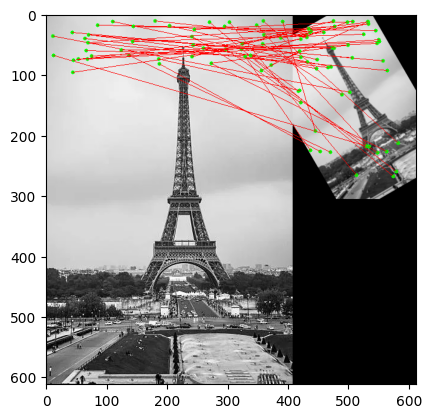

In [24]:
plt.imshow(image)

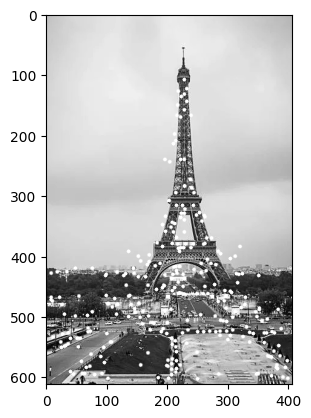

In [32]:
orig_image = cv2.imread("Eiffel1.webp", cv2.IMREAD_GRAYSCALE)
img = orig_image.astype(np.float32) / 255.0

gauss_pyr = generate_gaussian_pyramid(img)
dog_pyr = generate_dog_pyramid(gauss_pyr)
keypoints = detect_keypoints(dog_pyr)
oriented_kps = assign_orientation(img, keypoints)

for x, y, _ in oriented_kps:
    cv2.circle(orig_image, (int(x), int(y)), 3, (255, 0, 0), -1)

plt.imshow(orig_image, cmap='gray')
plt.show()